# Load Data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook

data_path = os. getcwd()[:-9] +'Data/'

In [2]:
# Binned every 15 mins, the bins are: 05, 20, 35, 50

# Data on live popularity, collected every 10min from 6am to 9pm
curpop_df = pd.read_csv(data_path+'curpop_df.csv', index_col=[0])

# Data based on photos taken from Huayi's roof.
# 0: safe. 1: unsafe. 2: not sure
image_label_df = pd.read_csv(data_path+'image_label.csv', index_col =[0])

# add weather data
#current_weather = pd.read_csv(data_path+'binned_current_log.csv')
weather_hist= pd.read_csv(data_path + 'binned_weather_history.csv')

# add surey data
survey = pd.read_csv(data_path+'Survey_clean.csv')

# add twitter data
tweet= pd.read_pickle(data_path + 'geotweets_labeled_binned.pkl')

In [4]:
# convert the columns 'datetime','binned', 'timetaken' to datetime objects
curpop_df.time_bin = pd.to_datetime(curpop_df.time_bin)
image_label_df.time_bin =pd.to_datetime(image_label_df.time_bin)
weather_hist.time_bin = pd.to_datetime(weather_hist.time_bin)
survey.time_bin = pd.to_datetime(survey.time_bin)
tweet.time_bin = pd.to_datetime(tweet.time_bin)

## Massage Data

In [5]:
# create label column for 'tweet' and reverse the sign to match with the other datasets
tweet['label'] = tweet.safe
tweet['label'][tweet.safe ==0] =1
tweet['label'][tweet.safe ==1] =0
# save
tweet.to_csv(data_path + 'geotweets_labeled_binned.csv')

C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
# average popularity within bins
curpop_df = curpop_df[['current_popularity','time_bin']].groupby('time_bin').mean()
curpop_df.reset_index(inplace= True)

In [7]:
# find the live popularity for each time bin that the photos/tweets/survey are collected
label_df=image_label_df.join(curpop_df.set_index('time_bin'), on='time_bin', how = 'inner')
twt_df=tweet.join(curpop_df.set_index('time_bin'), on='time_bin', how = 'inner')
survey_df= survey.join(curpop_df.set_index('time_bin'), on='time_bin', how = 'inner')

In [8]:
# impute some values for survey & create a column of 'label' 
# if not_main_track is not safe, and not sure about main_track, then, assume main_track is also not safe 
survey_df[(survey_df.main_track==2 ) & (survey_df.not_main_track==1)].main_track = 1
survey_df['label'] = survey_df.main_track # name it as'label' to be consistent

C:\Users\Huayi\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
# naively drop NAs
survey_df.dropna(inplace=True)
twt_df.dropna(inplace=True)

In [19]:
# make a populartimes df that contains all the positive datapoint from tweets & survey

# disregard unsure data point in the image data. 
# disregard any complicating data 

all_df = pd.concat([twt_df[['label','time_bin','current_popularity']], survey_df[['label','time_bin','current_popularity']], 
           label_df[['label','time_bin','current_popularity']]], ignore_index=True)
all_df.sort_values(by =  'time_bin', inplace=True)
all_df.reset_index(inplace=True, drop=True )

In [22]:
# save
all_df.to_csv(data_path + 'all_df.csv')
all_df.head(3)

,label,time_bin,current_popularity
0,0.0,2020-04-02 16:05:00,43.0
1,0.0,2020-04-02 16:50:00,47.5
2,0.0,2020-04-02 17:50:00,42.5


In [31]:
# get a sub dataset for training model
model_df = all_df[all_df.label!=2]
model_df = model_df.groupby('time_bin').mean()
model_df.label[model_df.label==0.5] =1
model_df.reset_index(inplace=True)

In [32]:
model_df.head(3)

,time_bin,label,current_popularity
0,2020-04-02 16:05:00,0.0,43.0
1,2020-04-02 16:50:00,0.0,47.5
2,2020-04-02 17:50:00,0.0,42.5


In [33]:
model_df.label.value_counts() # imblanced but not horrible 

0.0    46
1.0    20
Name: label, dtype: int64

In [34]:
model_df=model_df.join(weather_hist.set_index('time_bin'), on='time_bin', how = 'inner')

In [35]:
model_df.head(3)

,time_bin,label,current_popularity,time,temperature,dewpoint,humidity,precipitation,windspeed,winddirection,pressure
0,2020-04-02 16:05:00,0.0,43.0,NaN,52.07,-0.4,44.75,0.0,37.1,327.5,1004.8
1,2020-04-02 16:50:00,0.0,47.5,2020-04-02 17:00:00,55.04,-0.1,41.00,0.0,37.1,320.0,1004.2
2,2020-04-02 17:50:00,0.0,42.5,2020-04-02 18:00:00,57.02,0.2,39.00,0.0,44.6,320.0,1003.4


In [48]:
# make new columns to indicate the hour and day of week. 
model_df['hour'] = model_df.time_bin.dt.hour + model_df.time_bin.dt.minute/60
model_df['dayofweek'] = model_df.time_bin.dt.dayofweek

<IPython.core.display.Javascript object>


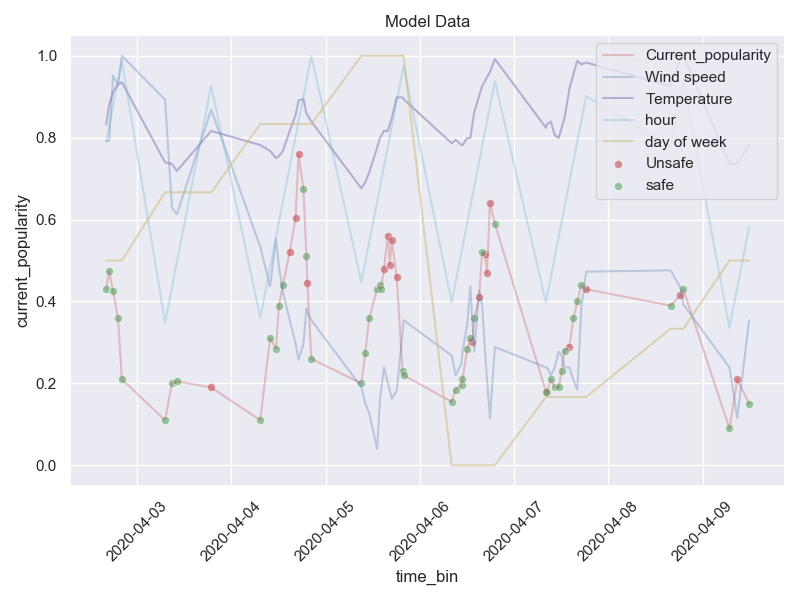

In [60]:
# plot that compare the raw timepoints with the binned result
plt.figure(figsize= [8,6])
sns.lineplot(model_df.time_bin, model_df.current_popularity/100, color = 'r', alpha = 0.3) # binned
sns.lineplot(model_df.time_bin, model_df.windspeed/(max(model_df.windspeed)), color = 'b', alpha = 0.3) # binned
sns.lineplot(model_df.time_bin, model_df.temperature/(max(model_df.temperature)), color = 'm', alpha = 0.5) # binned
sns.lineplot(model_df.time_bin, model_df.hour/max(model_df.hour), color = 'c', alpha = 0.3) # binned
sns.lineplot(model_df.time_bin, model_df.dayofweek/max(model_df.dayofweek), color = 'y', alpha = 0.5)

sns.scatterplot(model_df.time_bin[model_df.label==1], model_df.current_popularity[model_df.label==1]/100, color = 'r', alpha = 0.6)
sns.scatterplot(model_df.time_bin[model_df.label==0], model_df.current_popularity[model_df.label==0]/100, color = 'g', alpha = 0.6)
plt.xticks(rotation=45)
plt.title('Model Data')
plt.legend(['Current_popularity', 'Wind speed', 'Temperature','hour','day of week','Unsafe','safe'])
plt.tight_layout()
plt.show()

In [61]:
# make take a few columns  for model training
model_sm_df= model_df[['current_popularity','temperature','precipitation','windspeed','hour','dayofweek','label']]
model_sm_df.to_csv(data_path + 'model_sm_df.csv')

# Train a simplisitc model

In [62]:
from sklearn.model_selection import train_test_split
X = model_sm_df.iloc[:,:6]
y = model_sm_df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [63]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [64]:
from sklearn.metrics import classification_report

predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84        16
         1.0       0.57      0.67      0.62         6

    accuracy                           0.77        22
   macro avg       0.72      0.74      0.73        22
weighted avg       0.79      0.77      0.78        22



In [65]:
from sklearn.metrics import roc_auc_score, roc_curve

def roc_auc(model,model_name, X_test, y_test):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(model_name+': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(); plt.show()

No Skill: ROC AUC=0.500
clf: ROC AUC=0.719


<IPython.core.display.Javascript object>


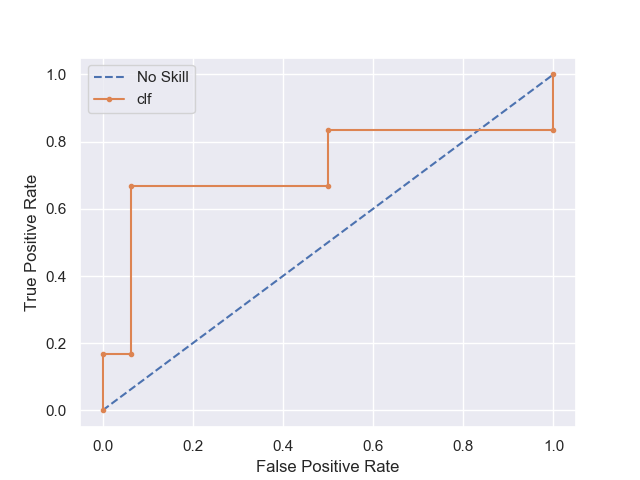

In [66]:
roc_auc(clf,'clf', X_test, y_test)

In [67]:
clf.coef_

array([[ 0.06496628,  0.15955907, -0.0030326 , -0.06278207, -0.12517506,
         0.17817711]])

# Try resampling

In [68]:
# to deal with unbalanced data, try upsampling
from sklearn.utils import resample

# Separate majority and minority classes
df_mj = model_sm_df[model_sm_df.label==0] # safe
df_mi = model_sm_df[model_sm_df.label==1] # unsafe
 
# Upsample minority class, with replacement 
df_mi_up = resample(df_mi, replace=True, n_samples=len(df_mj), random_state=101) 
 
# Combine majority class with upsampled minority class
df_up= pd.concat([df_mj, df_mi_up])
 
# Display new class counts
df_up.label.value_counts()

1.0    46
0.0    46
Name: label, dtype: int64

In [70]:
X_up = df_up.iloc[:,:6]
y_up = df_up.label

X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.33, random_state=40)

clf_up = LogisticRegression(random_state=0).fit(X_train_up, y_train_up)

In [71]:
predictions_up = clf_up.predict(X_test_up)
print(classification_report(y_test_up,predictions_up))

              precision    recall  f1-score   support

         0.0       0.67      0.53      0.59        15
         1.0       0.63      0.75      0.69        16

    accuracy                           0.65        31
   macro avg       0.65      0.64      0.64        31
weighted avg       0.65      0.65      0.64        31



No Skill: ROC AUC=0.500
clf_up: ROC AUC=0.771


<IPython.core.display.Javascript object>


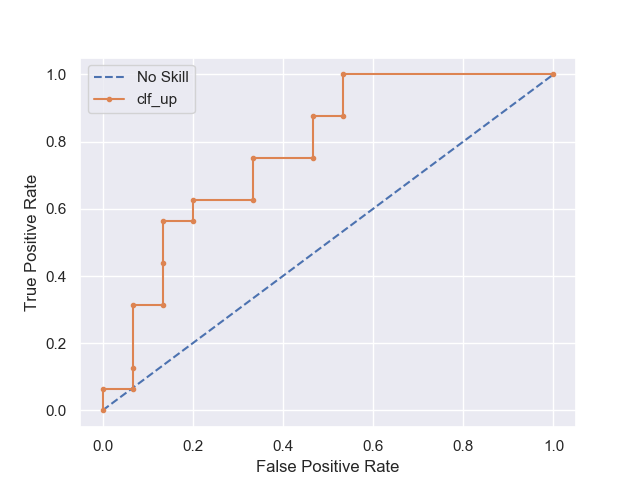

In [72]:
roc_auc(clf_up,'clf_up', X_test_up, y_test_up)

In [73]:
clf.coef_

array([[ 0.06496628,  0.15955907, -0.0030326 , -0.06278207, -0.12517506,
         0.17817711]])

## upsample both labels

In [74]:
n_target = 1000
 
# Upsample minority class, with replacement 
df_mi_re = resample(df_mi, replace=True, n_samples=n_target, random_state=101) 
df_mj_re = resample(df_mj, replace=True, n_samples=n_target, random_state=101) 
 
# Combine majority class with upsampled minority class
df_re= pd.concat([df_mj_re, df_mi_re])
 
# Display new class counts
df_re.label.value_counts()

1.0    1000
0.0    1000
Name: label, dtype: int64

In [75]:
X_re = df_re.iloc[:,:6]
y_re = df_re.label

X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X_re, y_re, test_size=0.33, random_state=42)

clf_re = LogisticRegression(random_state=0).fit(X_train_re, y_train_re)

In [76]:
predictions_re = clf_re.predict(X_test_re)
print(classification_report(y_test_re,predictions_re))

              precision    recall  f1-score   support

         0.0       0.75      0.74      0.75       325
         1.0       0.75      0.76      0.75       335

    accuracy                           0.75       660
   macro avg       0.75      0.75      0.75       660
weighted avg       0.75      0.75      0.75       660



No Skill: ROC AUC=0.500
clf_re: ROC AUC=0.781


<IPython.core.display.Javascript object>


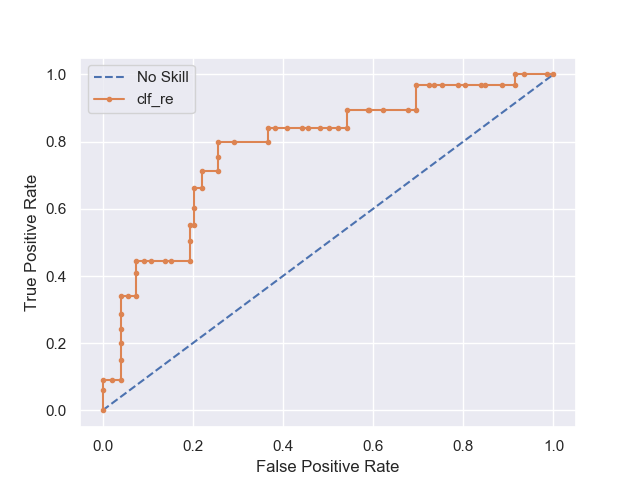

In [77]:
roc_auc(clf_re,'clf_re', X_test_re, y_test_re)

In [78]:
clf.coef_

array([[ 0.06496628,  0.15955907, -0.0030326 , -0.06278207, -0.12517506,
         0.17817711]])